# Variable-speed synfire chains

Conductance-based LIF network:

$$C_m^i \frac{dv^i}{dt} = g_l[E_l^i - V^i(t)] + g^i_e(t)[E_e - V^i(t)] + g^i_i(t)[E_i - V^i(t)] + I^i_{ext}(t)$$

The time-varying conductances $g^i_e$ and $g^i_i$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$ respectively.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## BASE MODEL
M = {
    # E membrane
    'C_M_E': 1e-6, 'G_L_E': .1e-3,  # T_M = C_M/G_L
    'E_L_E': -0.06, 'V_TH_E': -0.05, 'V_R_E': -0.06, 'T_R_E': 0.002,
    
    # I membrane
    'C_M_I': 1e-6, 'G_L_I': .2e-3,  # T_M = C_M_/G_L
    'E_L_I': -0.06, 'V_TH_I': -0.05, 'V_R_I': -0.06, 'T_R_I': 0.002,
    
    # syn rev potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002,
}

## SMLN
S = {
    'RNG_SEED': 0, 'DT': .0005
}

print('T_M_E =', 1000*M['C_M_E']/M['G_L_E'], 'ms')
print('T_M_I =', 1000*M['C_M_I']/M['G_L_I'], 'ms')

T_M_E = 10.0 ms
T_M_I = 5.0 ms


## Single excitatory neuron behavior

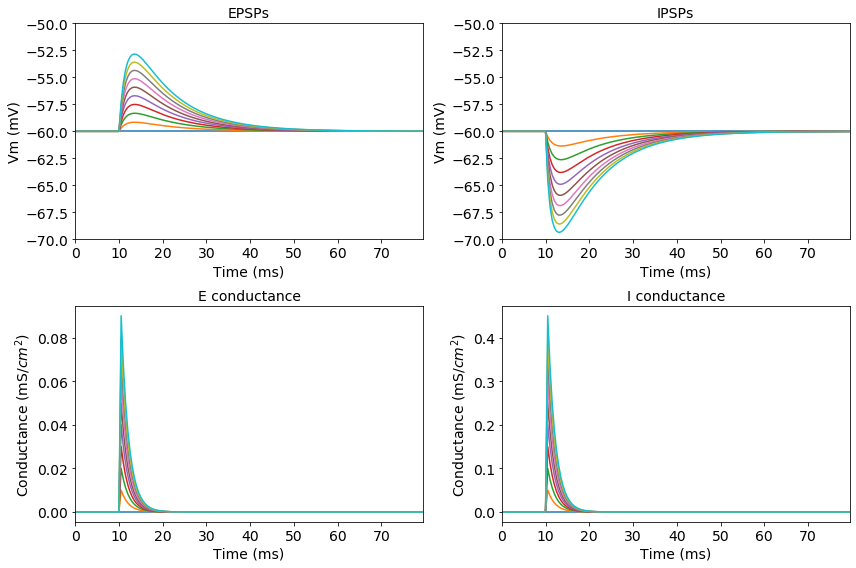

In [2]:
# EPSP size vs E weight
t = np.arange(0, .08, S['DT'])
rsps_e = []

for w_u_e_e in np.arange(10) * 0.01e-3:
    w_u_e_i = 0

    ntwk = LIFNtwkG(
        c_m=M['C_M_E'],
        g_l=M['G_L_E'],
        e_l=M['E_L_E'],
        v_th=M['V_TH_E'],
        v_r=M['V_R_E'],
        t_r=np.inf,
        e_s={'E': M['E_E'], 'I': M['E_I']},
        t_s={'E': M['T_E'], 'I': M['T_E']},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S['DT'])), 0] = 1
    rsp = ntwk.run(
        dt=S['DT'],
        clamp=Generic(v={0: np.array([M['V_R_E']])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_e.append(copy(rsp))
    

# IPSP size vs I weight
rsps_i = []

for w_u_e_i in np.arange(10) * 0.05e-3:
    w_u_e_e = 0

    ntwk = LIFNtwkG(
        c_m=M['C_M_E'],
        g_l=M['G_L_E'],
        e_l=M['E_L_E'],
        v_th=M['V_TH_E'],
        v_r=M['V_R_E'],
        t_r=np.inf,
        e_s={'E': M['E_E'], 'I': M['E_I']},
        t_s={'E': M['T_E'], 'I': M['T_E']},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S['DT'])), 1] = 1
    rsp = ntwk.run(
        dt=S['DT'],
        clamp=Generic(v={0: np.array([M['V_R_E']])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_i.append(copy(rsp))
    
    
# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
for rsp_e in rsps_e:
    axs[0, 0].plot(1000*t, 1000*rsp_e.vs[:, 0])
    axs[1, 0].plot(1000*t, 1000*rsp_e.gs['E'][:, 0])
for rsp_i in rsps_i:
    axs[0, 1].plot(1000*t, 1000*rsp_i.vs[:, 0])
    axs[1, 1].plot(1000*t, 1000*rsp_i.gs['I'][:, 0])
    
for ax in axs[0, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_ylim(-70, -50)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Vm (mV)')
    
for ax in axs[1, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Conductance (mS/$cm^2$)')
    
axs[0, 0].set_title('EPSPs')
axs[0, 1].set_title('IPSPs')

axs[1, 0].set_title('E conductance')
axs[1, 1].set_title('I conductance')
    
for ax in axs.flatten():
    set_font_size(ax, 14)

## Single chain link behavior



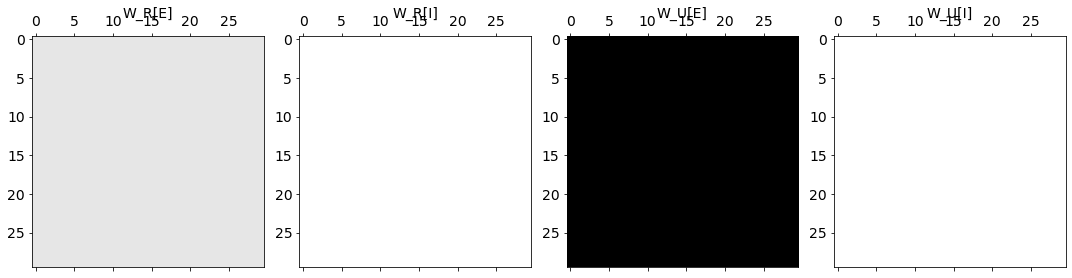

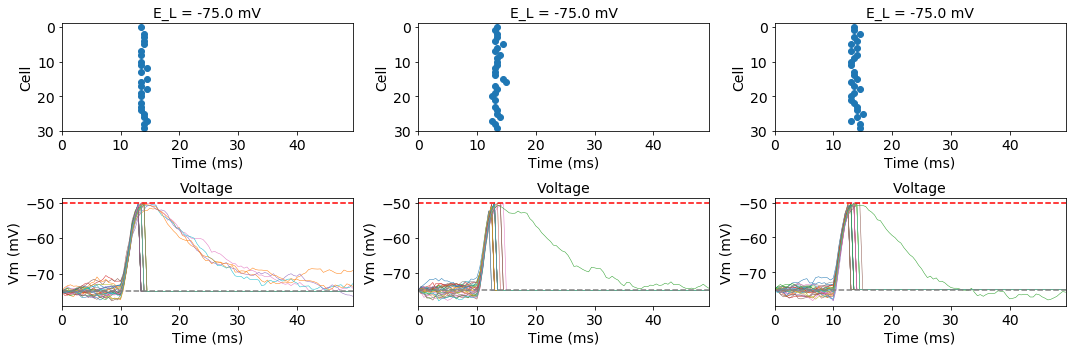

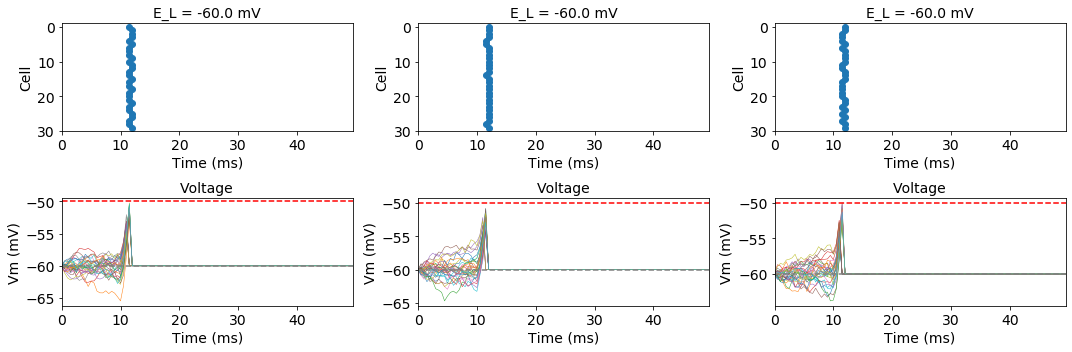

In [3]:
# ntwk params
m = copy(M)
m['N_L_E'] = 30  # num E nrns in chain link
m['E_L_E'] = -.075  # V
m['V_R_E'] = -.075  # V
m['W_E_E_R'] = 1e-6  # E->E recurrent cxns w/in link
m['W_E_E_F'] = 10e-6  # E->E feed-forward cxns btwn links
m['T_R_E'] = 1  # extra long refrac period (s)
m['SGM_N'] = .5e-9  # A*sqrt(s)
m['I_EXT_B'] =  0  #-.2e-5  # A

## E-E rcr weights
w_r = {
    'E': m['W_E_E_R'] * np.ones([m['N_L_E']]*2),
    'I': np.zeros((m['N_L_E'], m['N_L_E'])),
}

## input weights
w_u = {
    'E': m['W_E_E_F'] * np.ones([m['N_L_E']]*2),
    'I': np.zeros([m['N_L_E']]*2),
}

fig, axs = plt.subplots(1, 4, figsize=(15, 5), tight_layout=True)
axs[0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
axs[0].set_title('W_R[E]')
axs[1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
axs[1].set_title('W_R[I]')

axs[2].matshow(w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
axs[2].set_title('W_U[E]')
axs[3].matshow(w_u['I'], vmin=0, vmax=10e-6, cmap='binary')
axs[3].set_title('W_U[I]')

for ax in axs.flatten():
    set_font_size(ax, 14)

# response
N_TRL = 3
N_SPK_0 = 5

t = np.arange(0, .05, S['DT'])
t_u = [.01, .012]
t_mask = (t_u[0] <= t) & (t < t_u[1])

for e_l_e in [-.075, -.06]:
    m['E_L_E'] = e_l_e  # V
    m['V_R_E'] = e_l_e  # V
    
    ntwk = LIFNtwkG(
        c_m=m['C_M_E'],
        g_l=m['G_L_E'],
        e_l=m['E_L_E'],
        v_th=m['V_TH_E'],
        v_r=m['V_R_E'],
        t_r=m['T_R_E'],
        e_s={'E': m['E_E'], 'I': m['E_I']},
        t_s={'E': m['T_E'], 'I': m['T_E']},
        w_r=w_r,
        w_u=w_u)

    rsps = []
    for _ in range(N_TRL):

        clamp = Generic(
            v={0: np.repeat(m['E_L_E'], m['N_L_E'])}, spk={})

        ## external currents
        i_ext = m['SGM_N']/S['DT'] * np.random.randn(len(t), m['N_L_E']) + m['I_EXT_B']

        ## inp spks
        tmp = cc([np.ones(m['N_L_E'], int), np.zeros(m['N_L_E']*(t_mask.sum()-1))])

        spks_u = np.zeros((len(t), m['N_L_E']), dtype=int)
        spks_u[t_mask] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m['N_L_E'])

        rsp = ntwk.run(dt=S['DT'], clamp=clamp, i_ext=i_ext, spks_u=spks_u)
        rsps.append(copy(rsp))

    fig, axs = plt.subplots(2, N_TRL, figsize=(15, 5), tight_layout=True)

    for rsp, axs_ in zip(rsps, axs.T):
        # raster
        it_spk, c_spk = np.nonzero(rsp.spks)
        t_spk = it_spk * S['DT']
        axs_[0].scatter(1000*t_spk, c_spk)
        axs_[0].set_xlim(1000*t.min(), 1000*t.max())
        axs_[0].set_ylim(m['N_L_E'], -1)

        axs_[0].set_xlabel('Time (ms)')
        axs_[0].set_ylabel('Cell')
        axs_[0].set_title('E_L = {} mV'.format(1000*e_l_e))

        # voltages
        axs_[1].plot(1000*t, 1000*rsp.vs, lw=.5)
        axs_[1].axhline(1000*m['E_L_E'], c='gray', ls='--')
        axs_[1].axhline(1000*m['V_TH_E'], c='r', ls='--')
        axs_[1].set_xlim(1000*t.min(), 1000*t.max())

        axs_[1].set_xlabel('Time (ms)')
        axs_[1].set_ylabel('Vm (mV)')
        axs_[1].set_title('Voltage')

    for ax in axs.flatten():
        set_font_size(ax, 14)

## Full chain behavior

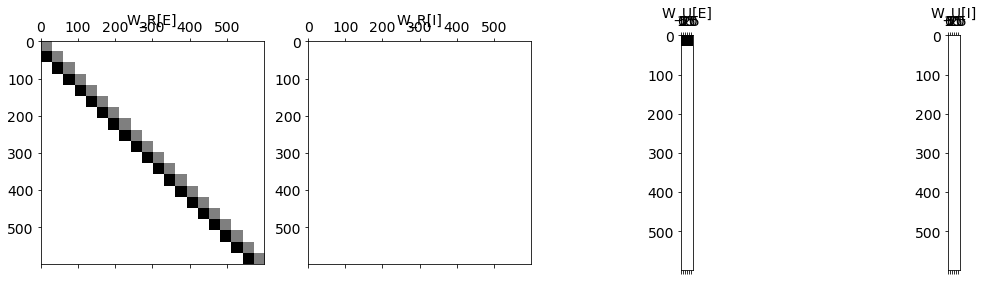

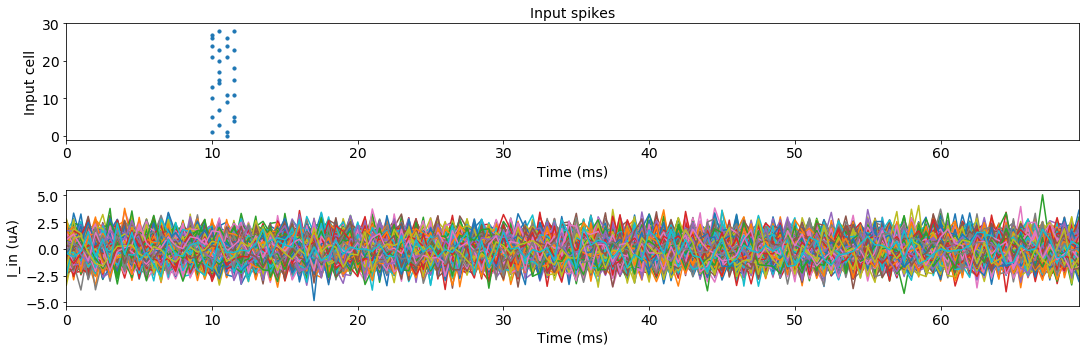

In [4]:
S['T'] = .07  # smln len

# ntwk params
m = copy(M)
m['N_L'] = 20  # num links
m['N_L_E'] = 30  # num E nrns in chain link
m['E_L_E'] = None  # V
m['V_R_E'] = None  # V
m['W_E_E_R'] = 0.005e-3  # E->E recurrent cxns w/in link
m['W_E_E_F'] = 0.01e-3  # E->E feed-forward cxns btwn links
m['T_R_E'] = 1  # extra long refrac period (s)
m['SGM_N'] = .5e-9  # A*sqrt(s)
m['I_EXT_B'] =  0  #-.2e-5  #

m['N_E'] = m['N_L']*m['N_L_E']


## E-E weights
w_r_e_e = \
    m['W_E_E_R'] * np.kron(np.eye(m['N_L'], k=0), np.ones([m['N_L_E']]*2)) + \
    m['W_E_E_F'] * np.kron(np.eye(m['N_L'], k=-1), np.ones([m['N_L_E']]*2))  # btwn links

w_r = {
    'E': w_r_e_e,
    'I': np.zeros((m['N_E'], m['N_E'])),
}

## input weights
w_u = {
    'E': cc([m['W_E_E_F']*np.ones([m['N_L_E']]*2), np.zeros([m['N_E']-m['N_L_E'], m['N_L_E']])]),
    'I': np.zeros([m['N_E'], m['N_L_E']]),
}

fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)
axs[0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
axs[0].set_title('W_R[E]')
axs[1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
axs[1].set_title('W_R[I]')

axs[2].matshow(w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
axs[2].set_title('W_U[E]')
axs[3].matshow(w_u['I'], vmin=0, vmax=10e-6, cmap='binary')
axs[3].set_title('W_U[I]')

for ax in axs.flatten():
    set_font_size(ax, 14)
    
# inputs
t = np.arange(0, S['T'], S['DT'])
t_u = [.01, .012]
t_mask = (t_u[0] <= t) & (t < t_u[1])

## external currents
i_ext = m['SGM_N']/S['DT'] * np.random.randn(len(t), m['N_E']) + m['I_EXT_B']

## inp spks
tmp = cc([np.ones(m['N_L_E'], int), np.zeros(m['N_L_E']*(t_mask.sum()-1))])

spks_u = np.zeros((len(t), m['N_L_E']), dtype=int)
spks_u[t_mask] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m['N_L_E'])

fig, axs = plt.subplots(2, 1, figsize=(15, 5), tight_layout=True)
t_spk_u, c_spk_u = np.nonzero(spks_u)
t_spk_u = t_spk_u * S['DT']

# input spikes
axs[0].scatter(1000*t_spk_u, c_spk_u, s=10)
axs[0].set_ylim(-1, spks_u.shape[1])
axs[0].set_title('Input spikes')
axs[0].set_ylabel('Input cell')

# input current
axs[1].plot(1000*t, 1e6*i_ext)
axs[1].set_ylabel('I_in (uA)')

for ax in axs:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_xlabel('Time (ms)')
    set_font_size(ax, 14)

Demo speed control via leak potential changes.

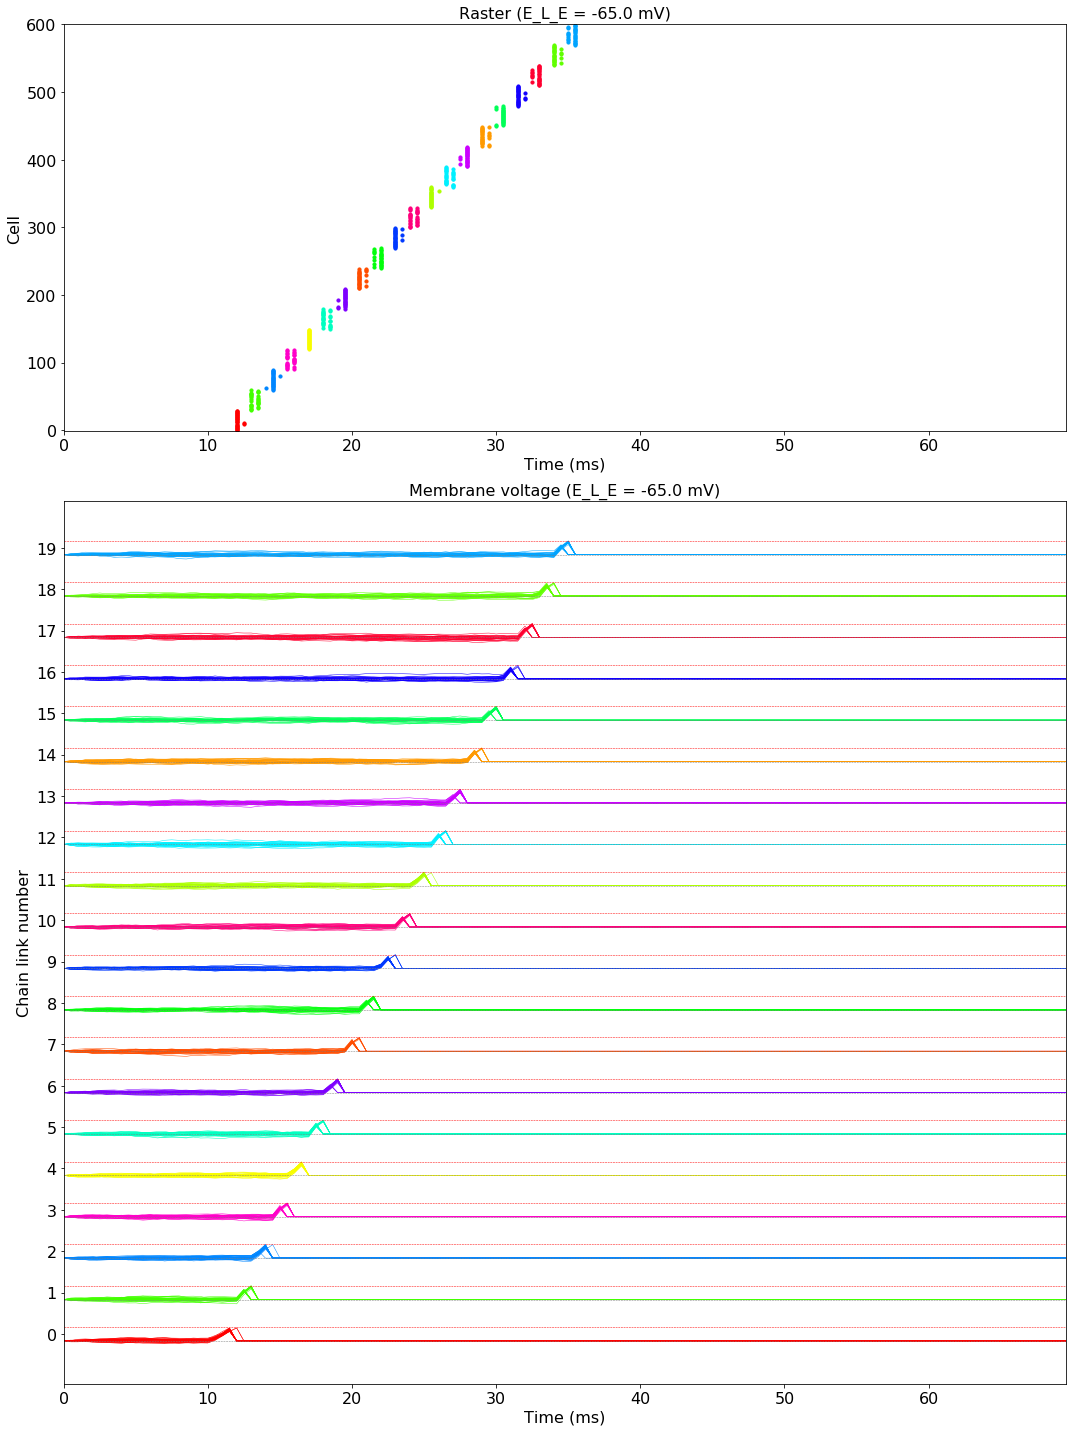

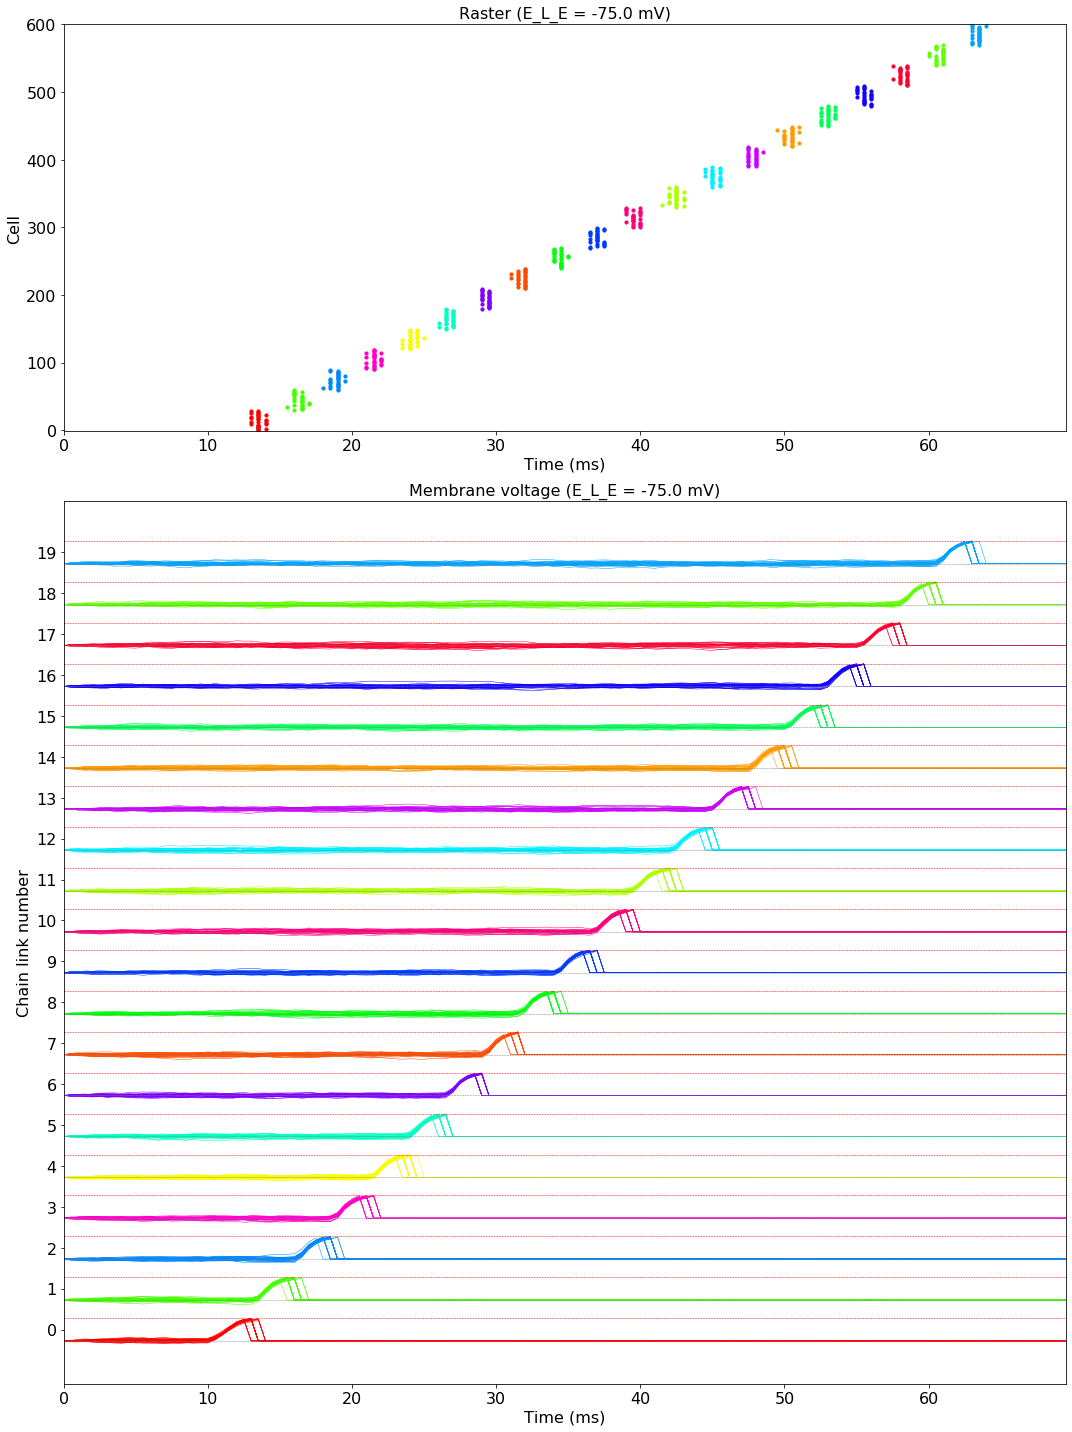

In [5]:
# make ntwk
E_L_E = [-.065, -.075]

for e_l_e in E_L_E:
    m['E_L_E'] = e_l_e
    m['V_R_E'] = e_l_e

    ntwk = LIFNtwkG(
        c_m=m['C_M_E'],
        g_l=m['G_L_E'],
        e_l=m['E_L_E'],
        v_th=m['V_TH_E'],
        v_r=m['V_R_E'],
        t_r=m['T_R_E'],
        e_s={'E': m['E_E'], 'I': m['E_I']},
        t_s={'E': m['T_E'], 'I': m['T_E']},
        w_r=w_r,
        w_u=w_u)

    clamp = Generic(
        v={0: np.repeat(m['E_L_E'], m['N_E'])}, spk={})

    # run smln
    rsp = ntwk.run(dt=S['DT'], clamp=clamp, i_ext=i_ext, spks_u=spks_u)

    # plot results (spks and voltage for each chain link)
    c = get_spaced_colors('hsv', m['N_L'], 75/256)
    v_space = 1.5 * (m['V_TH_E'] - m['E_I'])

    gs = gridspec.GridSpec(3, 1)
    fig = plt.figure(figsize=(15, 20), tight_layout=True)
    axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1:])]

    y_tick = []

    for l_ctr in range(m['N_L']):
        # spks & voltages for this link
        idx_start = l_ctr * m['N_L_E']
        idx_end = (l_ctr+1) * m['N_L_E']

        # raster
        t_spk, c_spk = rsp.spks[:, idx_start:idx_end].nonzero()
        t_spk = t_spk*S['DT']
        c_spk = c_spk + idx_start

        axs[0].scatter(1000*t_spk, c_spk, s=10, c=[c[l_ctr]])

        # voltages
        axs[1].plot(1000*t, 1000*(l_ctr*v_space + rsp.vs[:, idx_start:idx_end]), c=c[l_ctr], lw=.5)
        axs[1].axhline(1000*(l_ctr*v_space + m['E_L_E']), c='gray', ls='--', lw=.5)
        axs[1].axhline(1000*(l_ctr*v_space + m['V_TH_E']), c='r', ls='--', lw=.5)

        y_tick.append(1000 * (l_ctr*v_space + (m['E_L_E'] + m['V_TH_E'])/2))

    axs[0].set_ylim(-1, m['N_E'])
    axs[0].set_ylabel('Cell')
    axs[0].set_title('Raster (E_L_E = {} mV)'.format(1000*m['E_L_E']))

    axs[1].set_yticks(y_tick)
    axs[1].set_yticklabels(np.arange(m['N_L']))
    axs[1].set_ylabel('Chain link number')
    axs[1].set_title('Membrane voltage (E_L_E = {} mV)'.format(1000*m['E_L_E']))

    for ax in axs:
        ax.set_xlim(1000*t.min(), 1000*t.max())
        ax.set_xlabel('Time (ms)')
        set_font_size(ax, 16)